In [1]:
%load_ext autoreload
%autoreload 2


import numpy as np
import scqubits as scq


from qiskit_metal.analyses.quantization.lumped_capacitive import load_q3d_capacitance_matrix
from qiskit_metal.analyses.quantization.lom_core_analysis import CompositeSystem, Cell, Subsystem
                        
from scipy.constants import speed_of_light as c_light

import matplotlib.pyplot as plt
%matplotlib inline

11:42PM 58s INFO [__init__]: TransmonBuilder with system_type TRANSMON registered to QuantumSystemRegistry
11:42PM 58s INFO [__init__]: FluxoniumBuilder with system_type FLUXONIUM registered to QuantumSystemRegistry
11:42PM 58s INFO [__init__]: TLResonatorBuilder with system_type TL_RESONATOR registered to QuantumSystemRegistry
11:42PM 58s INFO [__init__]: LumpedResonatorBuilder with system_type LUMPED_RESONATOR registered to QuantumSystemRegistry


### 1. load fluxonium cell Q3d simulation results

Loading the Maxwell capacitance matrices for the design as shown in the screenshot below:

<img src="fluxonium_transmon_coupled.png" width=600 height=600 />


where we have a transmon coupled to a fluxonium through a direct coupler. 

For a simple introduction on Maxwell capacitance matrix, check out the following resources:
https://www.fastfieldsolvers.com/Papers/The_Maxwell_Capacitance_Matrix_WP110301_R02.pdf

In [2]:
path = './Fluxonium_8p5MHz_cmat.txt'
flux_mat, _, _, _ = load_q3d_capacitance_matrix(path)

Imported capacitance matrix with UNITS: [fF] now converted to USER UNITS:[fF]                 from file:
	./Fluxonium_8p5MHz_cmat.txt


,ground_main_plane,pad_bot_Q1,pad_top_Q1,coupling_pad_Q1
ground_main_plane,149.81,-24.45,-27.87,-35.54
pad_bot_Q1,-24.45,40.31,-5.38,-8.51
pad_top_Q1,-27.87,-5.38,36.66,-1.23
coupling_pad_Q1,-35.54,-8.51,-1.23,46.36


### load transmon cell Q3d simulation results

In [3]:
path = './Transmon_5p5GHz_fQ_cmat.txt'
transmon_mat, _, _, _ = load_q3d_capacitance_matrix(path)

Imported capacitance matrix with UNITS: [fF] now converted to USER UNITS:[fF]                 from file:
	./Transmon_5p5GHz_fQ_cmat.txt


,ground_main_plane,pad_bot_Q2,pad_top_Q2,coupling_pad_Q2
ground_main_plane,179.08,-38.07,-44.06,-36.24
pad_bot_Q2,-38.07,91.64,-31.54,-19.11
pad_top_Q2,-44.06,-31.54,81.23,-2.32
coupling_pad_Q2,-36.24,-19.11,-2.32,58.75


### 2. Create LOM cells from capacitance matrices
#### Setting cell objects corresponding to the capacitance simulation results 
`coupler_pad_Q1` and `coupler_pad_Q2` refer to the same node corresponding to the direct coupler between the qubits but are different names in the capacitance matrix results file. In order to merge the two capacitance matrices in the LOM analysis, we need to rename them to be the same name. 

The following three parameters, `ind_dict`, `jj_dict`, `cj_dict`, all have the same structure. Each is a dictionary where the keys are tuples, giving the nodes that a junction is in between, and the values specifying the relevant values associated with the junction. `ind_dict` lets you specify the junction inductance in nH; `jj_dict` specifies the Josephson junction name (you can give the junction any name you wish; just need to be consistent with the name); `cj_dict` specifies the junction capacitance in fF. In the case of the fluxonium, we will set $E_j$ and $E_l$ directly later instead of deriving from the junction inductance; and since we are only concerned with capacitive coupling here (what's currently supported), `ind_dict` can just be a placeholder whose actual value is not important.

In [4]:
# cell 1

opt1 = dict(
    node_rename = {'coupling_pad_Q1': 'coupling'}, 
    cap_mat = flux_mat,
    ind_dict = {('pad_bot_Q1', 'pad_top_Q1'): 1},  # placeholder inductance here; only used for node-basis transformation and reduction
    jj_dict = {('pad_bot_Q1', 'pad_top_Q1'):'j1'},
)
cell_1 = Cell(opt1)

# cell 2
opt2 = dict(
    node_rename = {'coupling_pad_Q2': 'coupling'},
    cap_mat = transmon_mat,
    ind_dict = {('pad_bot_Q2', 'pad_top_Q2'): 12.31},
    jj_dict = {('pad_bot_Q2', 'pad_top_Q2'):'j2'},
)
cell_2 = Cell(opt2)

### 3. Create subsystems
#### Creating the four subsystems, corresponding to the 2 qubits

`Subsystem` takes three required arguments. The four currently supported system types are `TRANSMON`, `FLUXONIUM`, `TL_RESONATOR` (transmission line resonator) and `LUMPED_RESONATOR`. `nodes` lets you specify which node the subsystem should be mapped to in the cells. They should be consistent with the node names you have given previously. `q_opts` lets specify any optional parameters you want to give. For example, for the fluxonium, you can provide `scqubits` parameters such as `EJ`, `EL` and `flux` here.

In [5]:
# subsystem 1: fluxonium
fluxonium = Subsystem(name='fluxonium', sys_type='FLUXONIUM', nodes=['j1'], q_opts={'EJ':4860, 'EL':1140, 'flux': .5})


# subsystem 2: transmon
transmon = Subsystem(name='transmon', sys_type='TRANSMON', nodes=['j2'], q_opts={'ncut': 150, 'truncated_dim':10})

### 4. Creat the composite system from the cells and the subsystems

In [6]:
composite_sys = CompositeSystem(
    subsystems=[fluxonium, transmon], 
    cells=[cell_1, cell_2], 
    grd_node='ground_main_plane')

The `circuitGraph` object encapsulates the lumped model circuit analysis (i.e., LOM analysis) and contain the intermediate as well as final L and C matrices, their inverses needed to construct the Hamiltonian of the composite system. For more details on the meaning and calculation of these matrices, check out https://arxiv.org/pdf/2103.10344.pdf.

Just to note that you can use the analysis without needing to know any detail about this object.

In [7]:
cg = composite_sys.circuitGraph()
print(cg)

node_jj_basis:
-------------

['j1', 'pad_top_Q1', 'j2', 'pad_top_Q2', 'coupling']

nodes_keep:
-------------

['j1', 'j2']


L_inv_k (reduced inverse inductance matrix):
-------------

     j1        j2
j1  1.0  0.000000
j2  0.0  0.081235

C_k (reduced capacitance matrix):
-------------

           j1         j2
j1  21.769175  -0.249771
j2  -0.249771  58.195757




### 5. Generate the hilberspace from the composite system, leveraging the scqubits package

`add_interaction()` adds the interaction terms between the subsystems. Currently, capacitive coupling is supported (which is extracted by from off-diagonal elements in the C matrices, see *eqn 12, 13* in https://arxiv.org/pdf/2103.10344.pdf ) and contribute to the interaction.

In [8]:
hilbertspace = composite_sys.create_hilbertspace()
hilbertspace = composite_sys.add_interaction()
print(hilbertspace)

HilbertSpace:  subsystems
-------------------------

Fluxonium-----------| [Fluxonium_2]
                    | EJ: 4860
                    | EC: 889.8446120935232
                    | EL: 1140
                    | flux: 0.5
                    | cutoff: 110
                    | truncated_dim: 10
                    |
                    | dim: 110


Transmon------------| [Transmon_2]
                    | EJ: 13278.758148398147
                    | EC: 332.8624670156746
                    | ng: 0.001
                    | ncut: 150
                    | truncated_dim: 10
                    |
                    | dim: 301



HilbertSpace:  interaction terms
--------------------------------
InteractionTerm----------| [Interaction_1]
                         | g_strength: 30.553058474092207
                         | operator_list: [(0, array([[ 0.+0.j        , -0.-0.44731161j,  0. ...
                         | add_hc: False




### 6. Print the results

Print the calculated Hamiltonian parameters from diagonalized composite system Hamiltonian.

The diagonal elements of the $\chi$ matrix are the anharmonicities of the respective subsystems and the off-diagonal the dispersive shifts between them.

In [9]:
hamiltonian_results = composite_sys.hamiltonian_results(hilbertspace, evals_count=30)


system frequencies in GHz:
--------------------------
{'fluxonium': 0.3601817422174963, 'transmon': 5.591162362502462}

Chi matrices in MHz
--------------------------
             fluxonium    transmon
fluxonium  3293.889946    0.451843
transmon      0.451843 -391.649924


In [10]:
hamiltonian_results['chi_in_MHz'].to_dataframe()

,fluxonium,transmon
fluxonium,3293.889946,0.451843
transmon,0.451843,-391.649924


The $\chi$'s between the subsystems are based on the coupling strengths, $\it{g}$'s between them (which are computed using the coupling capacitance (currently capacitive coupling is supported) and zero point fluctuations of the subsystem's charge operator at the coupling location)

In [11]:
composite_sys.compute_gs()

           j1         j2
j1   0.000000  30.553058
j2  30.553058   0.000000

In [12]:
fluxonium.h_params

defaultdict(dict,
            {'j1': {'EJ': 4860,
              'EC': 889.8446120935232,
              'EL': 1140,
              'flux': 0.5,
              'Q_zpf': 3.204353268e-19,
              'default_charge_op': Operator(op=array([[ 0.+0.j        , -0.-0.44731161j,  0.+0.j        , ...,
                       0.+0.j        ,  0.+0.j        ,  0.+0.j        ],
                     [ 0.+0.44731161j,  0.+0.j        , -0.-0.63259415j, ...,
                       0.+0.j        ,  0.+0.j        ,  0.+0.j        ],
                     [ 0.+0.j        ,  0.+0.63259415j,  0.+0.j        , ...,
                       0.+0.j        ,  0.+0.j        ,  0.+0.j        ],
                     ...,
                     [ 0.+0.j        ,  0.+0.j        ,  0.+0.j        , ...,
                       0.+0.j        , -0.-4.64859865j,  0.+0.j        ],
                     [ 0.+0.j        ,  0.+0.j        ,  0.+0.j        , ...,
                       0.+4.64859865j,  0.+0.j        , -0.-4.67007036j],

In [13]:
transmon.h_params

defaultdict(dict,
            {'j2': {'EJ': 13278.758148398147,
              'EC': 332.8624670156746,
              'Q_zpf': 3.204353268e-19,
              'default_charge_op': Operator(op=array([[-150,    0,    0, ...,    0,    0,    0],
                     [   0, -149,    0, ...,    0,    0,    0],
                     [   0,    0, -148, ...,    0,    0,    0],
                     ...,
                     [   0,    0,    0, ...,  148,    0,    0],
                     [   0,    0,    0, ...,    0,  149,    0],
                     [   0,    0,    0, ...,    0,    0,  150]]), add_hc=False)}})

### 7. let's sweep some parameters now

Let's sweep the flux from 0 to 1 in a grid of 100 points in unit of flux quantum using `scQubits`'s sweeping library.

In [14]:
 _sys = hilbertspace.subsys_list[0] # fluxonium

def update_hilbertspace(param_val):
    _sys.flux = param_val
    
param_name = 'flux'
param_vals = np.linspace(0, 1, 101)

sweep = scq.ParameterSweep(
    paramvals_by_name={param_name: param_vals},
    evals_count=30,
    hilbertspace=hilbertspace,
    subsys_update_info={param_name: [_sys]},
    update_hilbertspace=update_hilbertspace,
)

Bare spectra:   0%|          | 0/101 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/101 [00:00<?, ?it/s]

#### Plot transition frequencies as a function of the flux

0->1 transition for the transmon

0->1 transition for the fluxonium

0->2 transition for the fluxonium

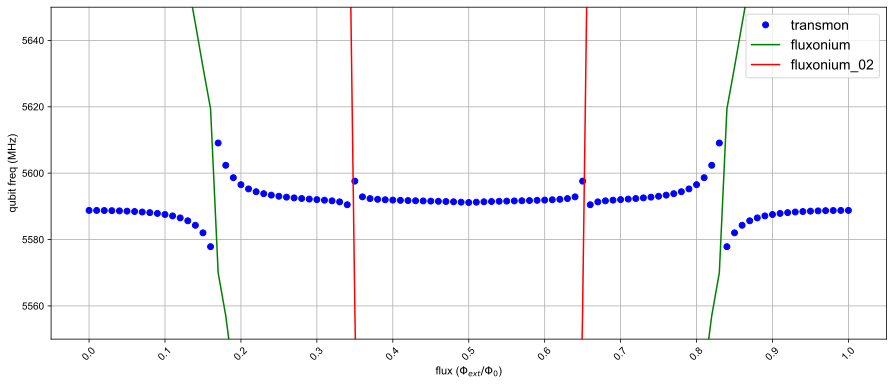

In [15]:
wq_t = sweep.transitions(False, [],(0, 0), (0, 1))[1][0]
wq_f = sweep.transitions(False, [],(0, 0), (1, 0))[1][0]
wq_f_02 = sweep.transitions(False, [],(0, 0), (2, 0))[1][0]


plt.figure(figsize=(15, 6))
plt.plot(param_vals, wq_t, 'ob', label='transmon')
plt.plot(param_vals, wq_f, 'g-', label='fluxonium')
plt.plot(param_vals, wq_f_02, 'r-', label='fluxonium_02')


plt.xticks(param_vals[::10], rotation=45)

plt.xlabel(r'flux ($\Phi_{ext}/\Phi_0$)')
plt.ylabel(r'qubit freq (MHz)')
plt.ylim([5550, 5650])

plt.grid()
plt.legend(fontsize=14)

#### The dispersive shift, $\chi$ between the two qubits as a function of the flux

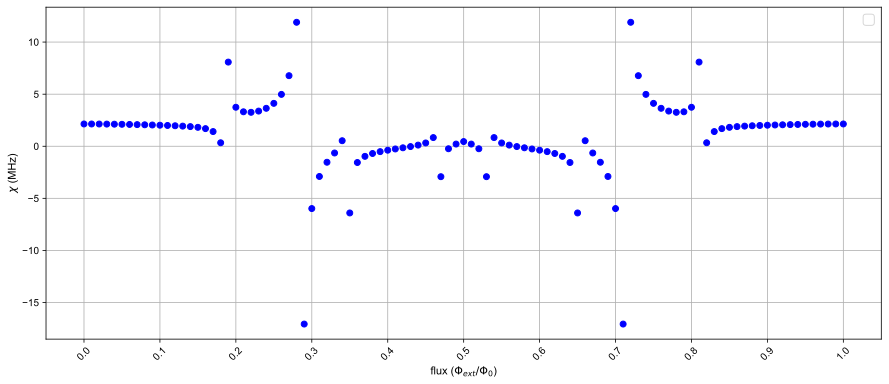

In [16]:
wq_f = sweep.transitions(False, [],(0, 0), (1, 0))[1][0]
wq_f_t = sweep.transitions(False, [],(0, 1), (1, 1))[1][0]


chi = wq_f_t - wq_f

plt.figure(figsize=(15, 6))
plt.plot(param_vals, chi, 'ob')

plt.xticks(param_vals[::10], rotation=45)

plt.xlabel(r'flux ($\Phi_{ext}/\Phi_0$)')
plt.ylabel(r'$\chi$ (MHz)')
#plt.ylim([5550, 5650])

plt.grid()
plt.legend(fontsize=14)

#### Zooming on the fluxonium sweet spot: its 0->1 transition as a function of the flux

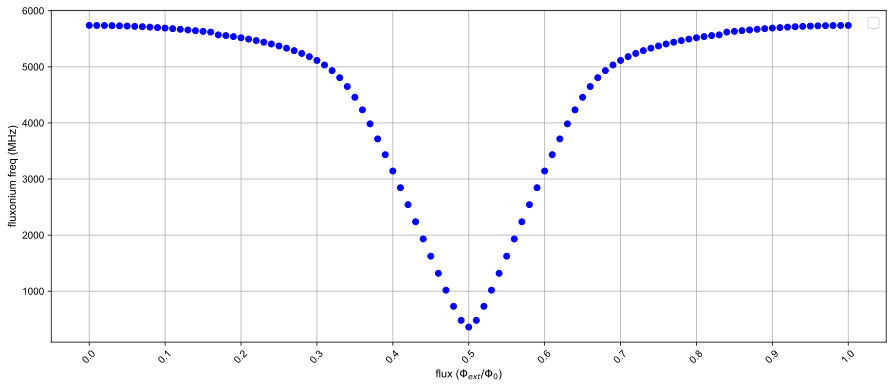

In [17]:
wq_f = sweep.transitions(False, [],(0, 0), (1, 0))[1][0]


plt.figure(figsize=(15, 6))
plt.plot(param_vals, wq_f, 'ob')


plt.xticks(param_vals[::10], rotation=45)

plt.xlabel(r'flux ($\Phi_{ext}/\Phi_0$)')
plt.ylabel(r'fluxonium freq (MHz)')

plt.grid()
plt.legend(fontsize=14)

In [18]:
scq.get_units()
scq.set_units('MHz')

 C:\Users\askev\AppData\Local\Programs\Python\Python310\lib\site-packages\scqubits\core\units.py: 48


'MHz'

#### Coherences of the fluxonium as a function of the flux

For more information on their calculations and assumptions made, check out `scqubits` documentations:
https://scqubits.readthedocs.io/en/latest/guide/guide-noise.html

Spectral data:   0%|          | 0/101 [00:00<?, ?it/s]

See documentation for details.
This warning can be disabled by executing:
scqubits.settings.T1_DEFAULT_WARNING=False

 C:\Users\askev\AppData\Local\Programs\Python\Python310\lib\site-packages\scqubits\core\noise.py: 1195


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 't1_effective'}, xlabel='flux', ylabel='$\\mu s$'>)

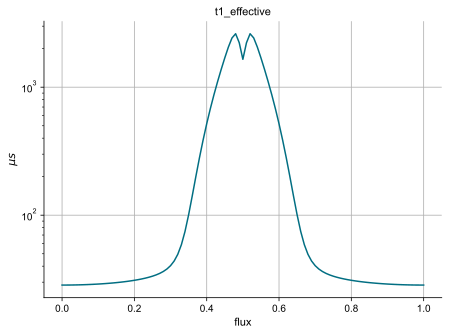

In [19]:
_sys.plot_t1_effective_vs_paramvals(param_name='flux', 
                                    param_vals=param_vals)

Spectral data:   0%|          | 0/101 [00:00<?, ?it/s]

(<Figure size 800x1200 with 8 Axes>,
 array([[<Axes: title={'center': 'tphi_1_over_f_cc'}, xlabel='flux', ylabel='$\\mu s$'>,
         <Axes: title={'center': 'tphi_1_over_f_flux'}, xlabel='flux', ylabel='$\\mu s$'>],
        [<Axes: title={'center': 't1_capacitive'}, xlabel='flux', ylabel='$\\mu s$'>,
         <Axes: title={'center': 't1_charge_impedance'}, xlabel='flux', ylabel='$\\mu s$'>],
        [<Axes: title={'center': 't1_flux_bias_line'}, xlabel='flux', ylabel='$\\mu s$'>,
         <Axes: title={'center': 't1_inductive'}, xlabel='flux', ylabel='$\\mu s$'>],
        [<Axes: title={'center': 't1_quasiparticle_tunneling'}, xlabel='flux', ylabel='$\\mu s$'>,
         <Axes: >]], dtype=object))

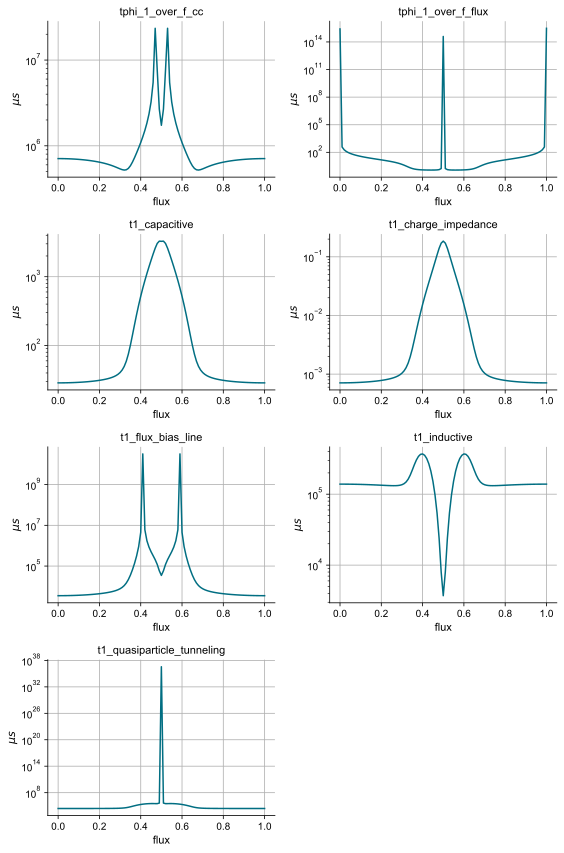

In [20]:
_sys.plot_coherence_vs_paramvals(param_name='flux', param_vals=param_vals)